Start by importing all of the packages that we are going to be using. I import visualizations, a python file that I've created, which contains a bunch of functions that produce visualizations to help with visualizing our data, and assessing our models. 

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report,precision_score, precision_recall_fscore_support as score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.cluster import FeatureAgglomeration
from sklearn import cluster
from imblearn.over_sampling import SMOTE
import keras
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical  
import itertools
from visualizations import *

Using TensorFlow backend.


# Data Visualization and Analysis of Credit Card Fraud Data

## Getting the Data

The dataset that we're going to be looking at today can be found on [Kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). It's a dataset of credit card transactions, and each one is marked as either a legitimate or a fraudulent transaction. We're going to see if we can use the information given to predict whether or not a transaction is legitimate.

Before building and sort of predictive model, we're going to want to load the data (I saved mine to a csv file called 'fraud.csv'), check for any null values in the data, and get a sense for what each column of data looks like. As explained on Kaggle, we have 28 continuous principal components of a credit card transaction dataset, the time of the transaction (measured in seconds from the time of the first transaction), and the amount of the transaction.

In [2]:
fraud = pd.read_csv('fraud.csv')
fraud.info()
fraud.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploration and Visualization

### The output

We're going to start by digging in to what this data actually *looks* like. A natural first place to start looking is how our output is distributed. It's pretty clear that a majority of the transactions in the dataset are legitimate, with only 0.172% of them marked as fraud. This will have some serious implications for how we go about building our model.

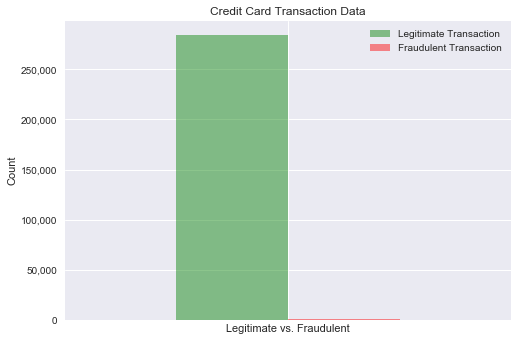

In [3]:
fraud_output = pd.DataFrame(columns = ['Legitimate Transaction', 'Fraudulent Transaction'])
counts = fraud['Class'].value_counts()
fraud_output.loc[0] = [counts[0],counts[1]]
bars = fraud_output.plot.bar(title = 'Credit Card Transaction Data', color = ['green','red'], alpha = 0.45)
bars.set_xlabel('Legitimate vs. Fraudulent')
plt.tick_params(labelbottom='off')  
bars.set_ylabel('Count')
bars.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

### The Inputs

#### Amount

Lets start by looking at the amount of each transaction. Visualization of the continuous histograms doesn't do too much for us, but we can note that the amount for the fraudulent transactions tends to be higher than that of the legitimate ones.

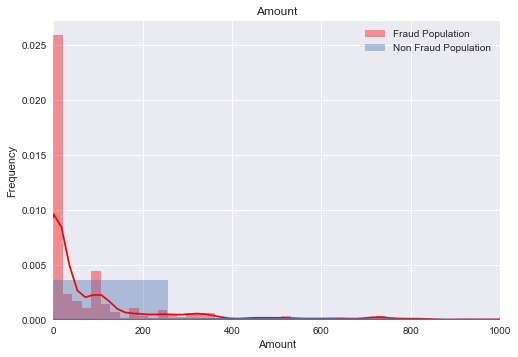

In [4]:
plot_cts_hist(fraud, 'Amount', 'Class', 100, 'Fraud', zoom = [0,1000]).show()
plt.close()

In [5]:
fraud.groupby('Class')['Amount'].mean()

Class
0     88.291022
1    122.211321
Name: Amount, dtype: float64

In [6]:
fraud.groupby('Class')['Amount'].std()

Class
0    250.105092
1    256.683288
Name: Amount, dtype: float64

#### Principal Components

Next lets look at the principal components that we are given. Since we don’t know what the principal components represent (by design of the dataset’s publisher), all we can really do is plot the distribution of each principal component. 

For the purposes of identifying fraudulent transactions it makes the most sense to plot the normalized (since the dataset is so imbalanced) frequency distributions of fraudulent transactions vs. legitimate transactions for each principal component. There are 28 of them, which I display below.

I found that the most interesting visualizations were produced by principal components 1, 2, 3, 4, 7, 9, 10, 11, 12, 14, 16, 17, 18, and 19. Generally speaking, the distributions that I found interesting fell into two main categories.

1. The means of each category were only slightly different, but the fraudulent transactions deviated from their mean far more than the legitimate ones did, resulting in a longer tail

2. The means of each category were very different, and the fraudulent transactions also displayed more spread out distributions, resulting in a longer tail

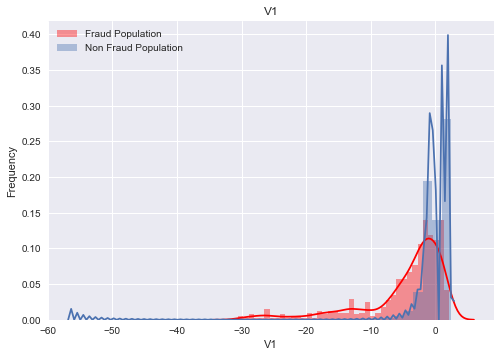

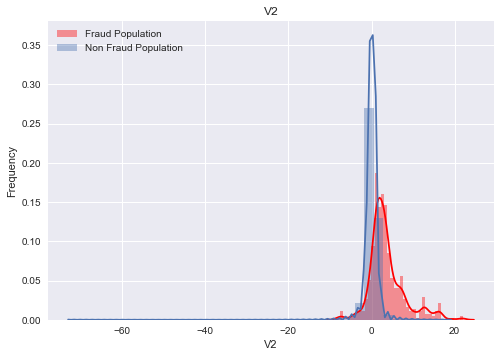

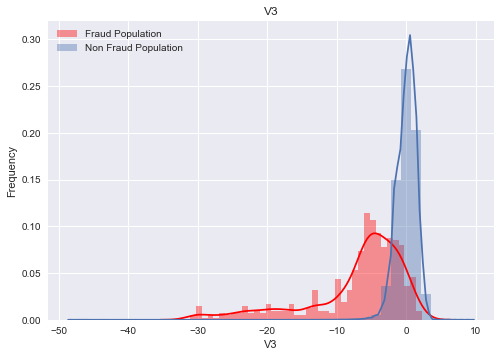

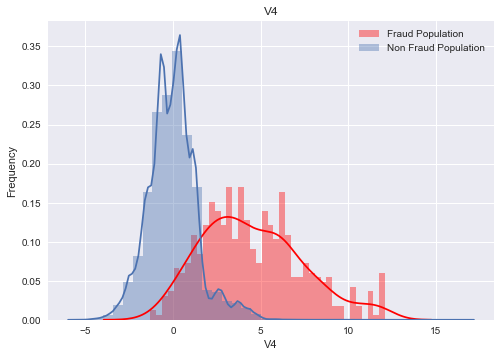

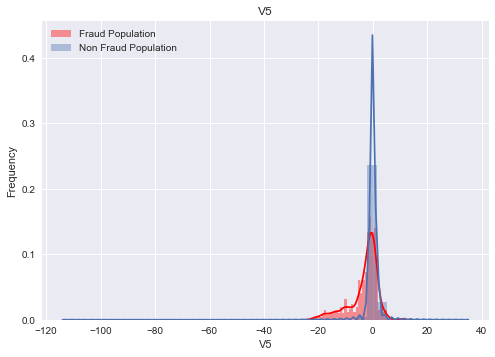

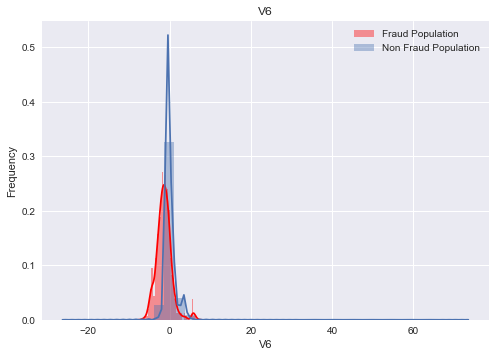

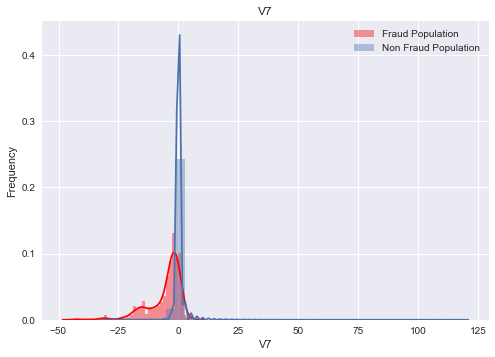

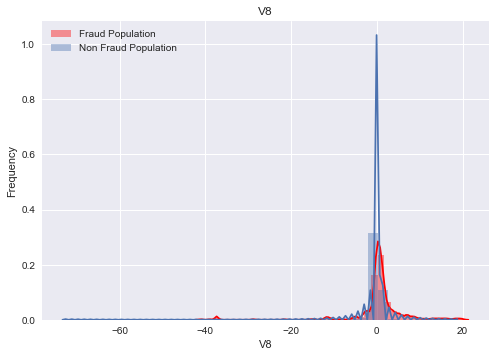

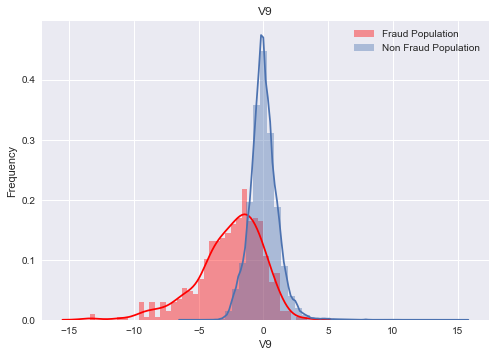

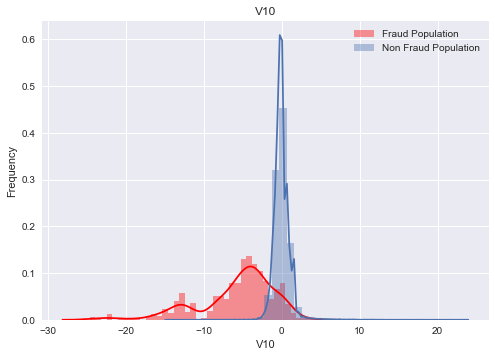

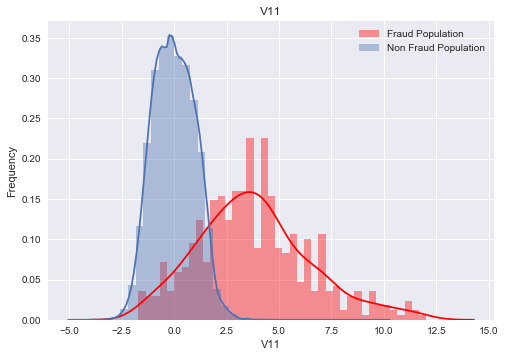

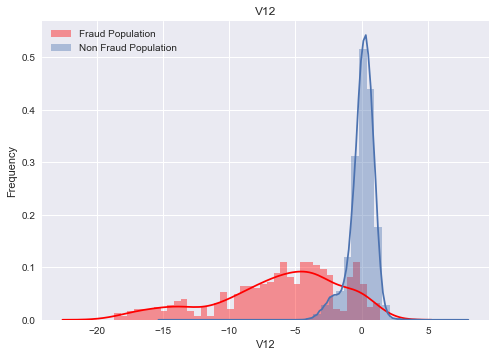

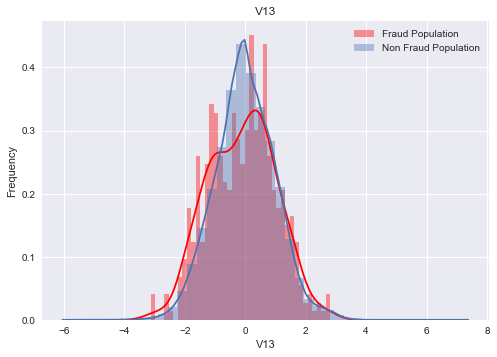

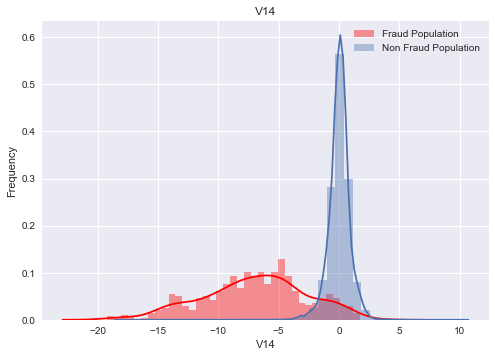

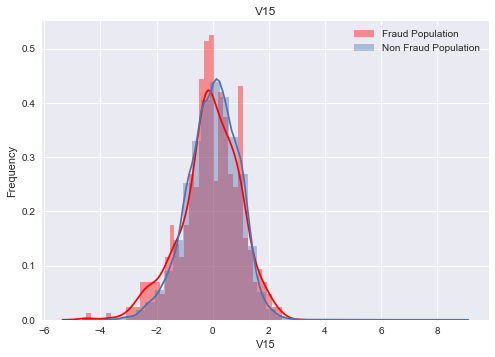

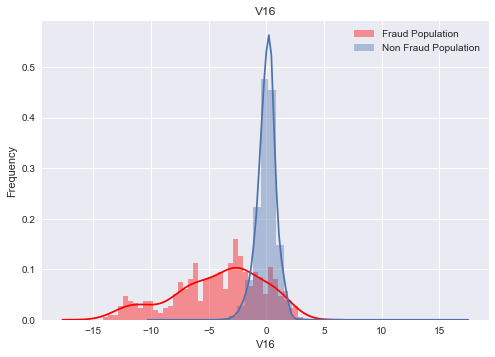

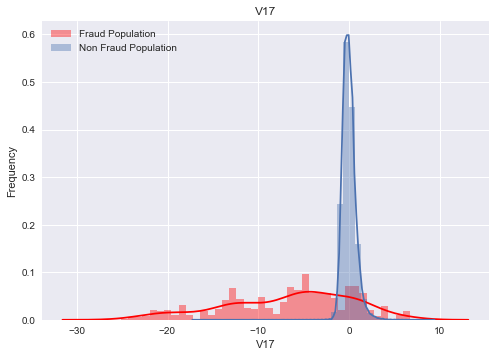

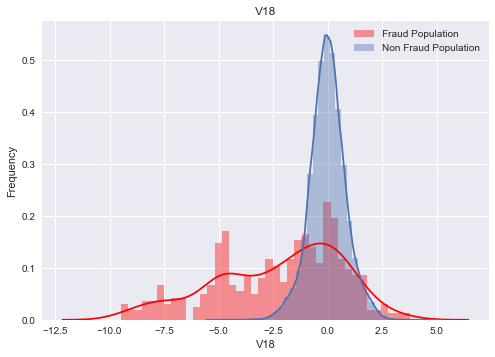

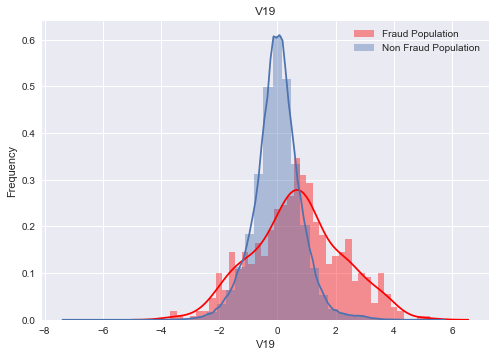

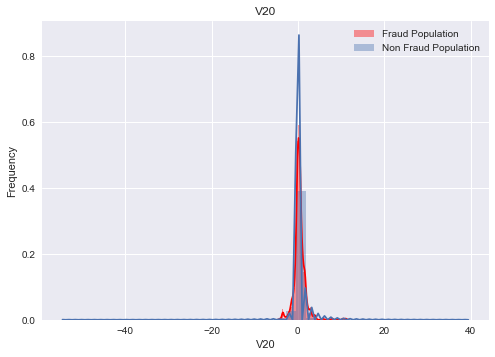

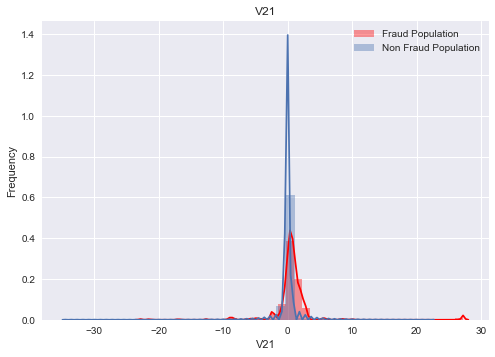

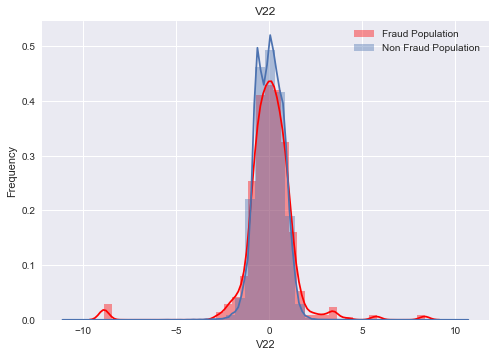

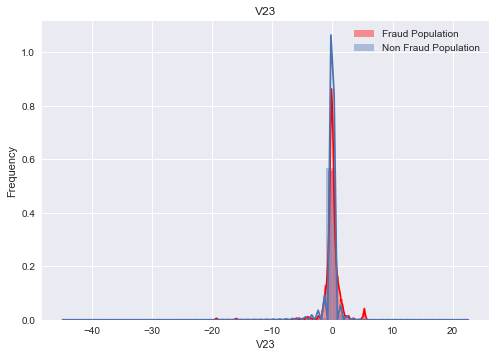

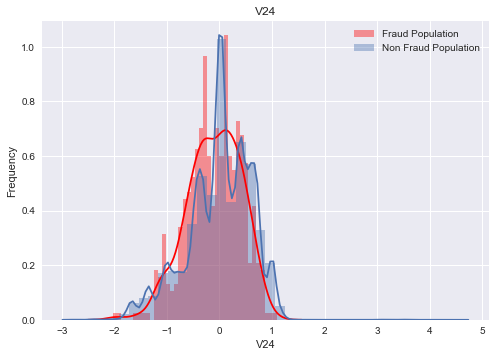

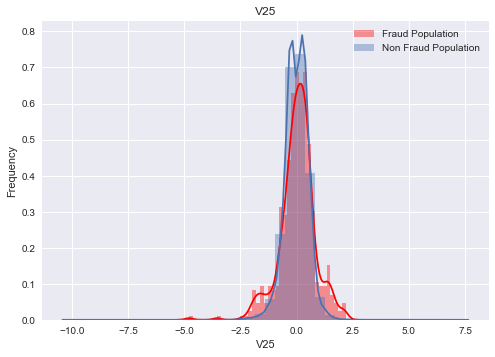

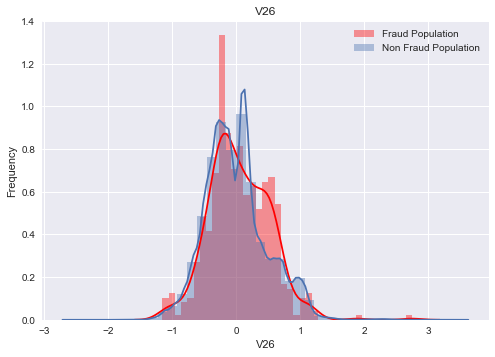

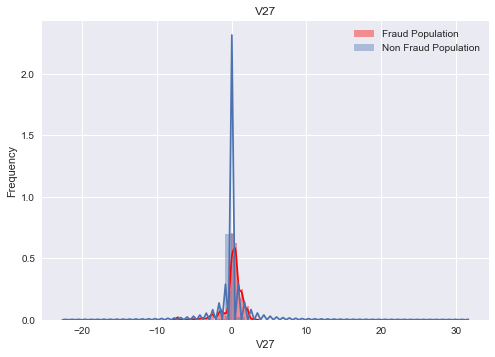

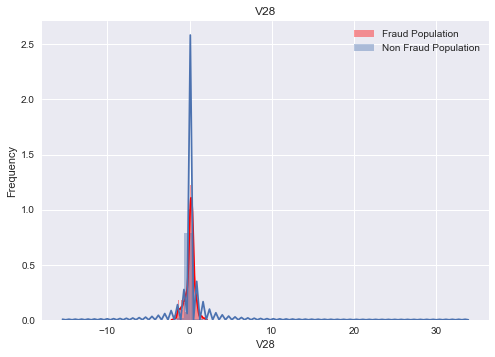

In [7]:
for i in range(1,29):
    plot_cts_hist(fraud,'V' + str(i), 'Class', 40,'Fraud').show()
    plt.close()

#### The Time Series

Next we should visualize the data as a time series. Plotting the principal components over time probably won't yield much, but we could plot our output over time to see if we can pick up any patterns in when fraudulent transactions take place. 

Firstly, it seems like the dataset only spans two days of transactions, and it's pretty clear that there is a cycle taking place. It looks like there is a 6 or 7 hour period of each day where legitimate transactions happen rarely, but the fraudulent transactions seem to not follow this same rule. These hours are likely late night/early morning hours of the day. 

Next I plot the fraud vs. legitimate transactions by minute of the day. This visualization will not show the cyclical nature of our dataset, but it will further confirm the difference in patterns between the legitimate/fraudulent transactions highlighted above. 

In [4]:
fraud['Second of Day'] = fraud['Time'] % (60*60*24)
fraud['Minute of Day'] = round(fraud['Second of Day'] / (60),0)

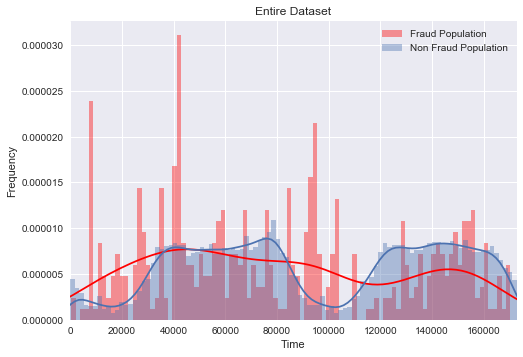

In [5]:
plot_cts_hist(fraud, 'Time', 'Class', 100, 'Fraud', zoom = [0,fraud['Time'].max()],title = 'Entire Dataset').show()

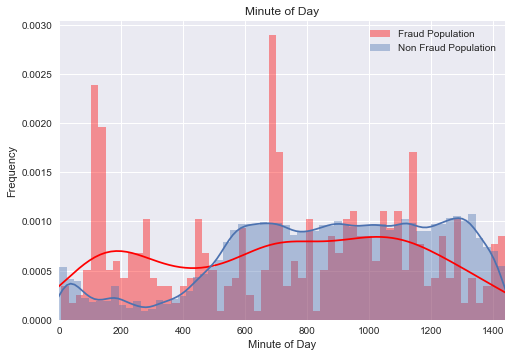

In [6]:
plot_cts_hist(fraud, 'Minute of Day', 'Class', 60, 'Fraud', zoom = [0,1440]).show()

## Preprocessing and Predictive Modeling

We begin by splitting the data into training and test sets. Next we take the mean and standard deviation of the training data and use it to normalize both the training and testing data. We do not include the observations in the test set in our calculations of the mean and the standard deviation to avoid overfitting the data.

In [7]:
X = fraud.drop(['Class', 'Second of Day', 'Minute of Day'],axis=1)
Y = fraud['Class']
X_tr, X_te, Y_tr, Y_te = train_test_split(X, Y, test_size=0.2)
X_tr = X_tr.values.astype('float32')
X_te = X_te.values.astype('float32')
Y_tr = Y_tr.values.astype('float32')
Y_te = Y_te.values.astype('float32')
mean = X_tr.mean(axis=0)
X_tr -= mean
X_te -= mean
std = X_tr.std(axis=0)
X_tr /= std
X_te /= std

### Objective

Before we begin modeling we must note that the output is very unbalanced. This has serious implications for our modeling, and we will explore several ways to tune a model to better handle this sort of output. The model statistics that we are going to be monitoring are precision, recall, and the f1-score. 

Since we are dealing with skewed data, we can’t just report on a models raw accuracy (correct guesses / total guesses). We must also rely on classification reports and confusion matrices to get the full picture of how well our model is performing. 

The two statistics in the classification reports that we monitor most closely are the precision and the recall for each class. Regardless of class both values are going to live in the range [0,1]. Precision tells us how accurate we are when we guess a certain category (regardless of whether or not we’ve captured every observation of that category). Recall, on the other hand, tells us what percentage of a given category we were able to pick up with in our model (regardless of how accurate we are in our predictions).

Before we get into any of the models we should talk a little bit about the actual *cost* of each type of misclassification. When a credit card transaction is marked as fraudulent the credit card company will probably block the transaction and send a text to the cardholder, at which point we’ll know if our model made the correct guess. If the transaction is actually fraudulent then we caught the bad guy and saved the company some money! The cost of of getting the guess wrong is delaying the cardholder’s transaction by a few seconds.

What about when we guess that the transaction is legitimate? If we’re right then the transaction goes through and everybody is happy. When we’re wrong, on the other hand, we allow a fraudulent transaction to go through which will ultimately cost the cardholder his/her time, and the company their money.

Every company is different, and some might value their customer’s time more than they value their money, so determining the optimal sweet spot probably varies for each company’s cost profile. For my analysis I just assume that we are trying to get almost all of the fraudulent transactions, while not needing to spend too much time checking up on legitimate transactions. 

### Models

#### Logistic Regression

We start with a simple logistic regression. Logistic regressions are great for binary classification. The out of the box logistic regression performs rather poorly, only being able to pick up on around 56% of the fraudulent transactions. 

In [14]:
# Plots the precision, recall, and fscore for given probability cutoffs
def plot_cutoffs(clf, cutoffs, X_tr, Y_tr, X_te, Y_te, recall = False, precision = False, fscore = False, acc = False):
    '''
        inputs:
            clf: the classifier function 
            cutoffs: the cutoffs you want to test (list or numpy array)
            X_tr, Y_tr, X_te, Y_te: numpy arrays which contain the training and testing data
            recall: bool, will plot recall for each category
            precision: bool, will plot precision for each category
            fscore: bool, will plot fscore for each category
            if all are false will just plot all 3 for output category 1
    '''
    fscores_0 = []
    fscores_1 = []
    recalls_0 = []
    recalls_1 = []
    accs = []
    precisions_0 = []
    precisions_1 = []
    cutoffs = np.array(cutoffs)
    clf = clf.fit(X_tr,Y_tr)
    predict_proba = clf.predict_proba(X_te)
    for cutoff in cutoffs:
        predictions = predict_proba[:,1] > cutoff
        recalls,precisions,fscores,support = score(predictions, Y_te)
        precisions_0.append(precisions[0])
        precisions_1.append(precisions[1])
        recalls_0.append(recalls[0])
        recalls_1.append(recalls[1])
        fscores_0.append(fscores[0])
        fscores_1.append(fscores[1])
        accs.append(clf.score(predictions,Y_te))
    if recall:
        plt.plot(cutoffs,np.array(recalls_0),label='Recall Category 0')
        plt.plot(cutoffs,np.array(recalls_1),label='Recall Category 1')
        plt.plot(cutoffs,np.array(accs),label='Model Accuracy')
    elif precision:
        plt.plot(cutoffs,np.array(precisions_0),label='Precision Category 0')
        plt.plot(cutoffs,np.array(precisions_1),label='Precision Category 1')    
    elif fscore:
        plt.plot(cutoffs,np.array(fscores_0),label='F-Score Category 0')
        plt.plot(cutoffs,np.array(fscores_1),label='F-Score Category 1') 
    elif acc:
        plt.plot(cutoffs,np.array(recalls_1),label='Recall Category 1')
        plt.plot(cutoffs,np.array(accs),label='Model Accuracy')
    else:
        plt.plot(cutoffs,np.array(recalls_1),label='Recall')
        plt.plot(cutoffs,np.array(precisions_1),label='Precision')
        plt.plot(cutoffs,np.array(fscores_1),label='F-Score')
    plt.xlabel('Cutoff')
    plt.ylabel('Score')
    plt.title('Model Statistics by Probability Cutoff')
    plt.legend()
    plt.show()
    plt.close()

    return 


Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     56862
        1.0       0.85      0.68      0.76       100

avg / total       1.00      1.00      1.00     56962



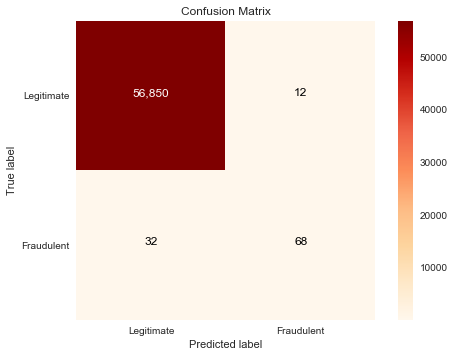

In [12]:
logreg = LogisticRegression()
lr = logreg.fit(X_tr,Y_tr)
predictions = lr.predict(X_te)
plot_confusion_matrix(Y_te,predictions,['Legitimate','Fraudulent']).show()
plt.close()

The first thing I try to tune is the output class weights which can be specific with the `class_weight` hyperparameter of the logistic regression object. For more details on this you should check out my visualization file. I choose to display how the precision, recall, and f1-score change as you vary the weight for fraudulent transactions. 

I use the visualizations to narrow my search for the optimal class weight down. It seems like we can maximize our recall while maintaining a good bit of precision with a class weight of 4.5.

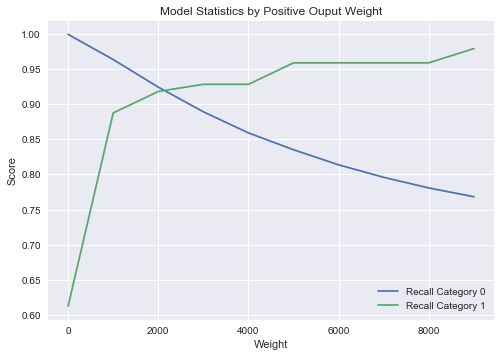

In [15]:
plot_weights(LogisticRegression(),weights = np.arange(1.0, 10000, 1000), X_tr = X_tr, Y_tr = Y_tr, X_te = X_te, Y_te = Y_te, recall = True)

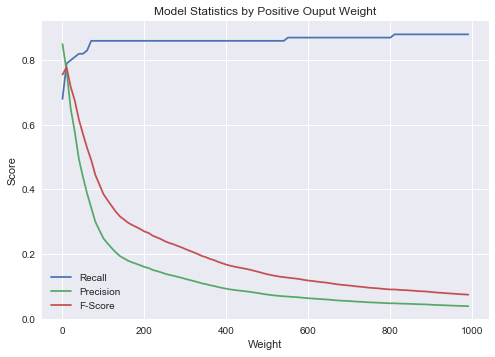

In [22]:
plot_weights(LogisticRegression(),weights = np.arange(1.0, 1000, 10), X_tr = X_tr, Y_tr = Y_tr, X_te = X_te, Y_te = Y_te)

If we weight the positive output by 4.5 we are able to boost our recall quite a bit, while not taking too huge of a hit on our precision. We're able to pick up 78% of the fraudulent transactions as legitimate in the testing set.


Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      0.96      0.98     56862
        1.0       0.04      0.88      0.07       100

avg / total       1.00      0.96      0.98     56962



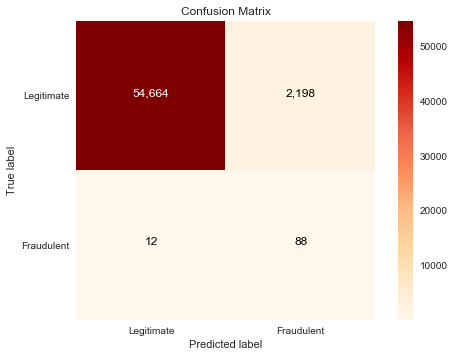

In [20]:
logreg = LogisticRegression(class_weight = {0:1.,1:1000})
lr = logreg.fit(X_tr,Y_tr)
predictions = lr.predict(X_te)
plot_confusion_matrix(Y_te,predictions,['Legitimate','Fraudulent']).show()
plt.close()

The next thing we can do is utilize the fact that what our logistic regression actually outputs a probability distribution for the output. By default we take the larger of the two probabilities and guess that as the ouput. What we can do is, instead, change the cutoff value for when we begin classifying an observation as fraud. I plot some model statistics as you vary the cutoff.

/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



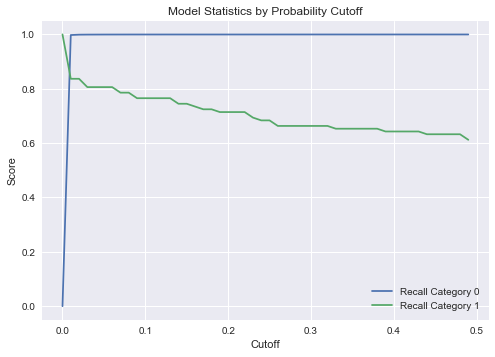

In [8]:
plot_cutoffs(LogisticRegression(),cutoffs = np.arange(0,.5,.01), X_tr = X_tr, Y_tr = Y_tr, X_te = X_te, Y_te = Y_te, recall = True)

/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



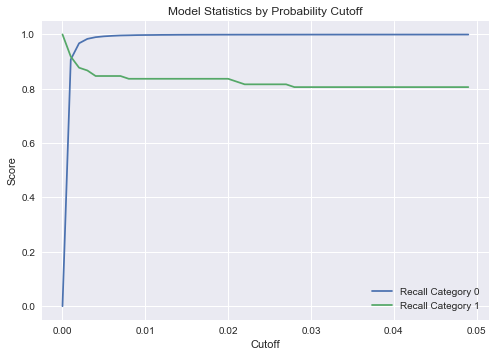

In [9]:
plot_cutoffs(LogisticRegression(),cutoffs = np.arange(0,.05,.001), X_tr = X_tr, Y_tr = Y_tr, X_te = X_te, Y_te = Y_te, recall = True)


Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     56877
        1.0       0.97      0.78      0.86        85

avg / total       1.00      1.00      1.00     56962



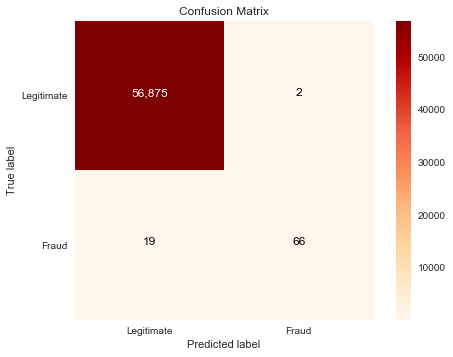

In [63]:
clf = RandomForestClassifier()
clf.fit(X_tr, Y_tr)
predictions = clf.predict(X_te)
plot_confusion_matrix(Y_te,predictions,['Legitimate','Fraud']).show()
plt.close()
predict_proba = clf.predict_proba(X_te)

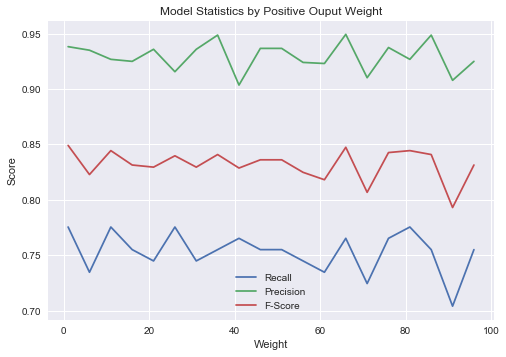

In [10]:
plot_weights(RandomForestClassifier(),weights=np.arange(1.0, 100, 5), X_tr = X_tr, Y_tr = Y_tr, X_te = X_te, Y_te = Y_te)

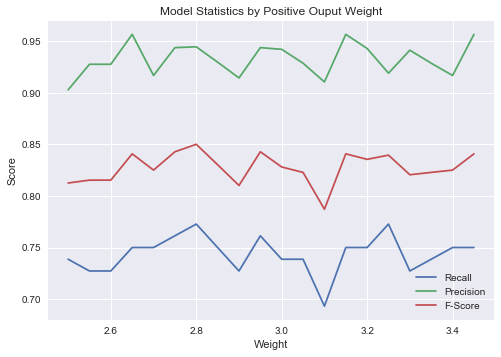

In [25]:
plot_weights(RandomForestClassifier(),weights=np.arange(2.5, 3.5, .05), X_tr = X_tr, Y_tr = Y_tr, X_te = X_te, Y_te = Y_te)


Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     56874
        1.0       0.93      0.76      0.84        88

avg / total       1.00      1.00      1.00     56962



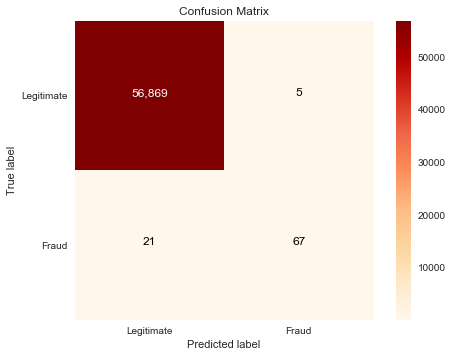

In [24]:
clf = RandomForestClassifier(class_weight = {0:1.,1:2.8})
clf.fit(X_tr, Y_tr)
predictions = clf.predict(X_te)
plot_confusion_matrix(Y_te,predictions,['Legitimate','Fraud']).show()
plt.close()
predict_proba = clf.predict_proba(X_te)

In [64]:
################ Oversample ##################
sm = SMOTE(ratio = 'minority')
X_over, Y_over = sm.fit_sample(X_tr, Y_tr)


Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     56877
        1.0       0.92      0.82      0.87        85

avg / total       1.00      1.00      1.00     56962



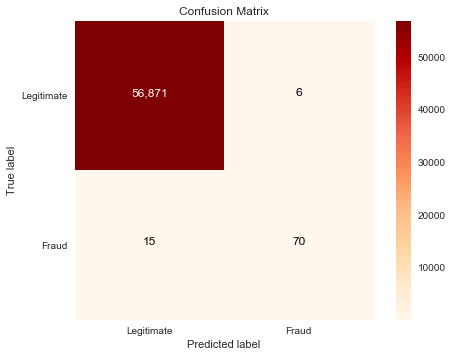

In [65]:
clf = RandomForestClassifier()
clf.fit(X_over, Y_over)
predictions = clf.predict(X_te)
plot_confusion_matrix(Y_te,predictions,['Legitimate','Fraud']).show()
plt.close()
predict_proba = clf.predict_proba(X_te)

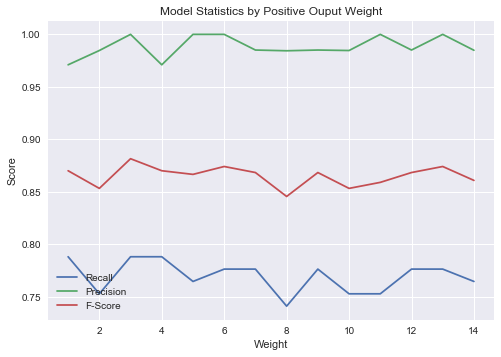

In [71]:
plot_weights(RandomForestClassifier(),weights=np.arange(1.,15.,1.), X_tr = X_tr, Y_tr = Y_tr, X_te = X_te, Y_te = Y_te)


Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      0.97      0.99     56877
        1.0       0.05      0.94      0.10        85

avg / total       1.00      0.97      0.99     56962



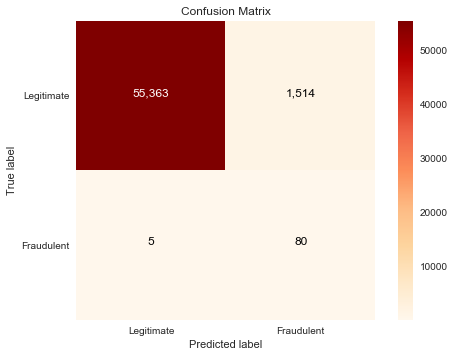

In [101]:
logreg = LogisticRegression(penalty = 'l1')
lr = logreg.fit(X_over,Y_over)
predictions = lr.predict(X_te)
plot_confusion_matrix(Y_te,predictions,['Legitimate','Fraudulent']).show()
plt.close()

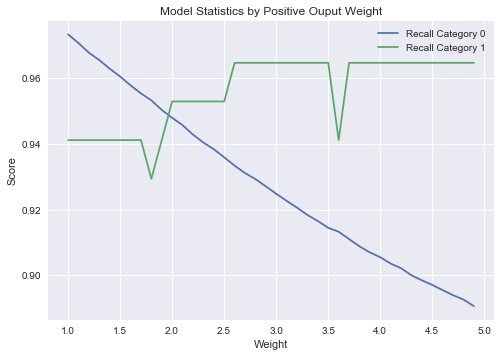

In [131]:
plot_weights(LogisticRegression(penalty = 'l1'), np.arange(1,5,.1), X_over, Y_over, X_te, Y_te, recall = True)

/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



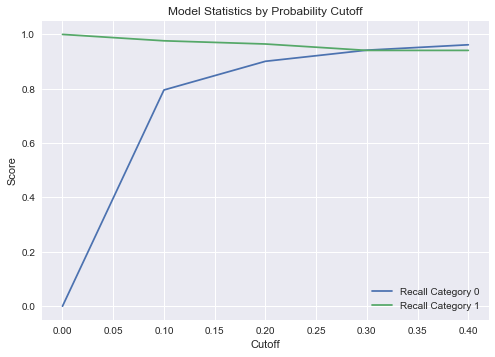

In [129]:
plot_cutoffs(LogisticRegression(penalty = 'l1'), np.arange(0,0.5,.1), X_over, Y_over, X_te, Y_te, recall = True)

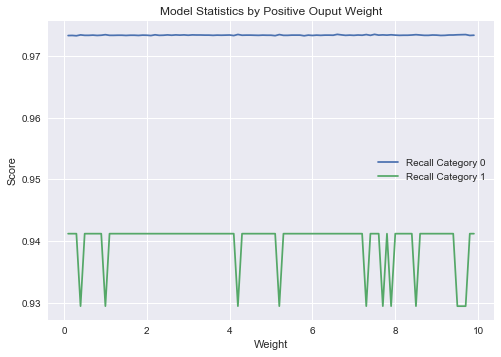

In [137]:
plot_cs(LogisticRegression(penalty = 'l1'), np.arange(0.1,10,.1), X_over, Y_over, X_te, Y_te, recall = True)


Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      0.93      0.97     56877
        1.0       0.02      0.94      0.04        85

avg / total       1.00      0.93      0.96     56962



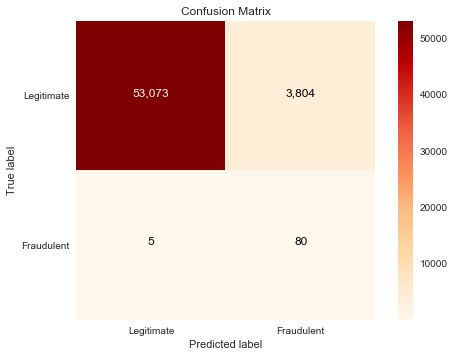

In [130]:
logreg = LogisticRegression(penalty = 'l1')
lr = logreg.fit(X_over,Y_over)
predict_proba = logreg.predict_proba(X_te)
predictions = predict_proba[:,1] > .27    
plot_confusion_matrix(Y_te,predictions,['Legitimate','Fraudulent']).show()
plt.close()


Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      0.92      0.96     56877
        1.0       0.02      0.96      0.04        85

avg / total       1.00      0.92      0.96     56962



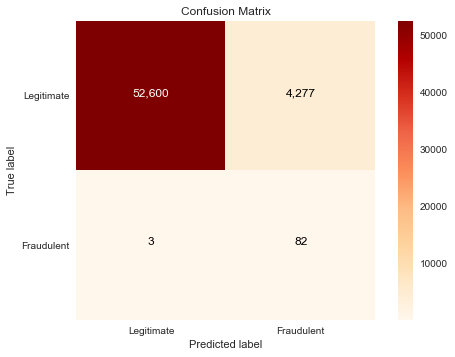

In [114]:
logreg = LogisticRegression(penalty = 'l1', class_weight = {0:1.,1:3.0})
lr = logreg.fit(X_over,Y_over)
predictions = lr.predict(X_te)
plot_confusion_matrix(Y_te,predictions,['Legitimate','Fraudulent']).show()
plt.close()

In [ ]:
# clf = RandomForestClassifier()
# param_grid = {
#     'n_estimators' : [10,50,100,250],
#     'min_samples_leaf' : [1,4,10],
#     'max_features': ['auto','sqrt','log2',None]
# }
# clf = GridSearchCV(clf, param_grid)
# clf.fit(X_tr,Y_tr)
# predictions = clf.predict(X_te)
# plot_confusion_matrix(Y_te,predictions,['Legitimate','Fraud']).show()
# plt.close()

In [97]:
model = models.Sequential()
# model.add(layers.Dense(5096, activation='relu', input_shape=(30,)))
# model.add(keras.layers.BatchNormalization())
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(2048, activation='relu', input_shape=(30,)))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))#, input_shape=(30,)))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

#adadelta best
model.compile(optimizer = keras.optimizers.Adadelta(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [keras.callbacks.EarlyStopping(monitor = 'acc',patience = 2)]

history = model.fit(X_tr,
                    Y_tr,
                    epochs=25,
                    batch_size=512,
                    callbacks = callbacks,
                    validation_data=(X_te, Y_te),
                    class_weight = {0:1., 1: 100000})

Train on 227845 samples, validate on 56962 samples
Epoch 1/25
227845/227845 [==============================] - 109s 477us/step - loss: 60.0028 - acc: 0.4420 - val_loss: 0.2120 - val_acc: 0.9522
Epoch 2/25
227845/227845 [==============================] - 103s 453us/step - loss: 15.6499 - acc: 0.4012 - val_loss: 0.1757 - val_acc: 0.9535
Epoch 3/25
227845/227845 [==============================] - 102s 446us/step - loss: 7.1924 - acc: 0.3952 - val_loss: 0.2471 - val_acc: 0.9005


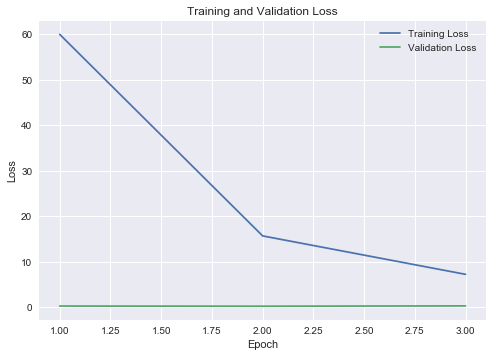

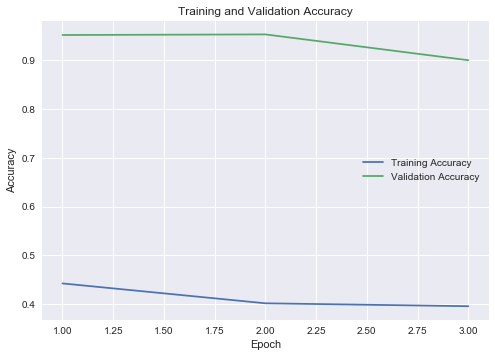


Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      0.90      0.95     56877
        1.0       0.01      0.95      0.03        85

avg / total       1.00      0.90      0.95     56962



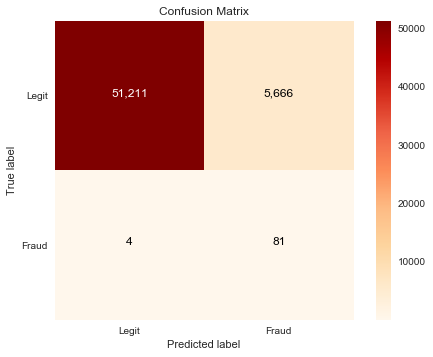

In [98]:
dnn_plots(history)
predictions = model.predict_classes(X_te)
plot_confusion_matrix(Y_te, predictions,['Legit','Fraud']).show()

In [99]:
model = models.Sequential()
# model.add(layers.Dense(5096, activation='relu', input_shape=(30,)))
# model.add(keras.layers.BatchNormalization())
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(2048, activation='relu', input_shape=(30,)))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

#adadelta best
model.compile(optimizer = keras.optimizers.Adadelta(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [keras.callbacks.EarlyStopping(monitor = 'acc',patience = 1)]

history = model.fit(X_over,
                    Y_over,
                    epochs=25,
                    batch_size=128,
                    callbacks = callbacks,
                    validation_data=(X_te, Y_te),
                    class_weight = {0:1., 1: 500})

Train on 454876 samples, validate on 56962 samples
Epoch 1/25
454876/454876 [==============================] - 204s 448us/step - loss: 3.8491 - acc: 0.9253 - val_loss: 0.0373 - val_acc: 0.9924
Epoch 2/25
454876/454876 [==============================] - 197s 433us/step - loss: 0.3883 - acc: 0.9519 - val_loss: 0.0746 - val_acc: 0.9842
Epoch 3/25
454876/454876 [==============================] - 199s 437us/step - loss: 0.2958 - acc: 0.9631 - val_loss: 0.1064 - val_acc: 0.9800
Epoch 4/25
454876/454876 [==============================] - 200s 439us/step - loss: 0.2646 - acc: 0.9680 - val_loss: 0.1207 - val_acc: 0.9763
Epoch 5/25
454876/454876 [==============================] - 199s 438us/step - loss: 0.2264 - acc: 0.9724 - val_loss: 0.1082 - val_acc: 0.9788
Epoch 6/25
454876/454876 [==============================] - 199s 437us/step - loss: 0.2332 - acc: 0.9736 - val_loss: 0.1659 - val_acc: 0.9694
Epoch 7/25
454876/454876 [==============================] - 200s 439us/step - loss: 0.2284 - acc:

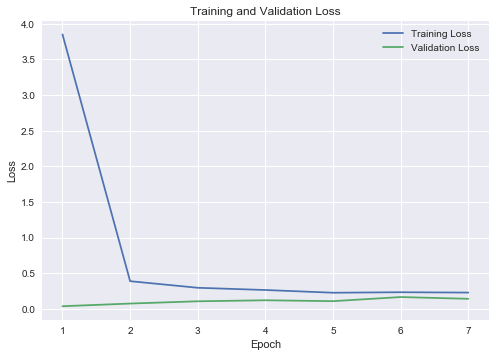

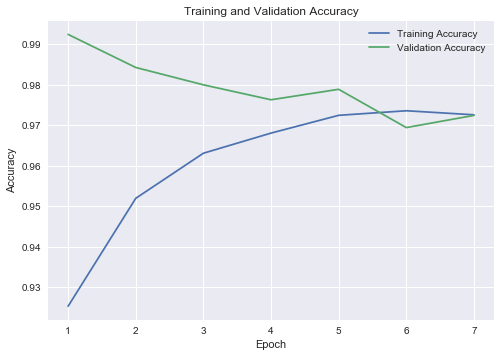


Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      0.97      0.99     56877
        1.0       0.05      0.93      0.09        85

avg / total       1.00      0.97      0.98     56962



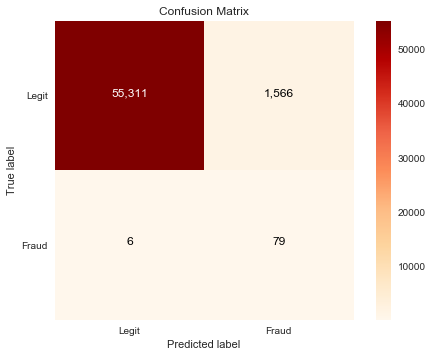

In [100]:
# Weight 500 different batch_size
dnn_plots(history)
predictions = model.predict_classes(X_te)
plot_confusion_matrix(Y_te, predictions,['Legit','Fraud']).show()

In [88]:
model = models.Sequential()
# model.add(layers.Dense(5096, activation='relu', input_shape=(30,)))
# model.add(keras.layers.BatchNormalization())
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(2048, activation='relu', input_shape=(30,)))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

#adadelta best
model.compile(optimizer = keras.optimizers.Adadelta(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [keras.callbacks.EarlyStopping(monitor = 'acc',patience = 1)]

history = model.fit(X_over,
                    Y_over,
                    epochs=25,
                    batch_size=512,
                    callbacks = callbacks,
                    validation_data=(X_te, Y_te),
                    class_weight = {0:1., 1: 100})

Train on 454876 samples, validate on 56962 samples
Epoch 1/25
454876/454876 [==============================] - 245s 538us/step - loss: 0.9436 - acc: 0.9514 - val_loss: 0.0226 - val_acc: 0.9950
Epoch 2/25
454876/454876 [==============================] - 250s 549us/step - loss: 0.1436 - acc: 0.9794 - val_loss: 0.0414 - val_acc: 0.9906
Epoch 3/25
454876/454876 [==============================] - 230s 506us/step - loss: 0.1155 - acc: 0.9836 - val_loss: 0.0428 - val_acc: 0.9907
Epoch 4/25
454876/454876 [==============================] - 235s 517us/step - loss: 0.1157 - acc: 0.9851 - val_loss: 0.0447 - val_acc: 0.9899
Epoch 5/25
454876/454876 [==============================] - 227s 499us/step - loss: 0.0962 - acc: 0.9878 - val_loss: 0.0463 - val_acc: 0.9902
Epoch 6/25
454876/454876 [==============================] - 229s 503us/step - loss: 0.0981 - acc: 0.9879 - val_loss: 0.0432 - val_acc: 0.9896
Epoch 7/25
454876/454876 [==============================] - 232s 510us/step - loss: 0.0906 - acc:

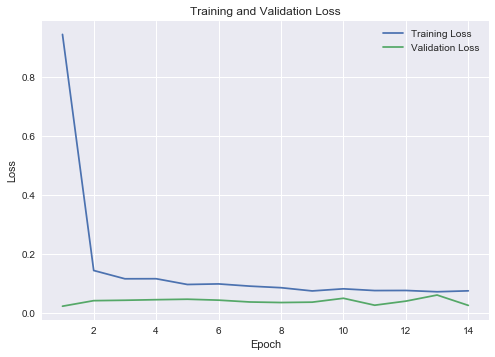

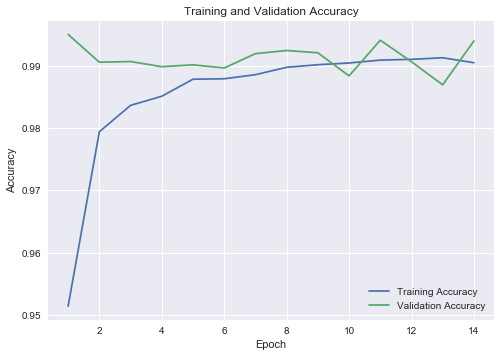


Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      0.99      1.00     56877
        1.0       0.19      0.91      0.31        85

avg / total       1.00      0.99      1.00     56962



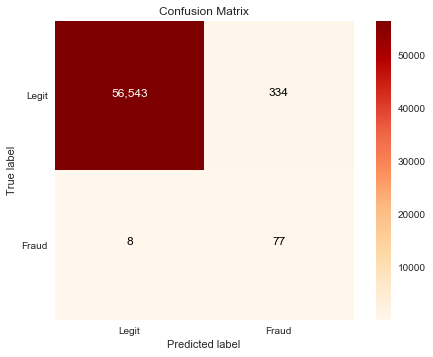

In [89]:
# Weight 100 different batch_size
dnn_plots(history)
predictions = model.predict_classes(X_te)
plot_confusion_matrix(Y_te, predictions,['Legit','Fraud']).show()

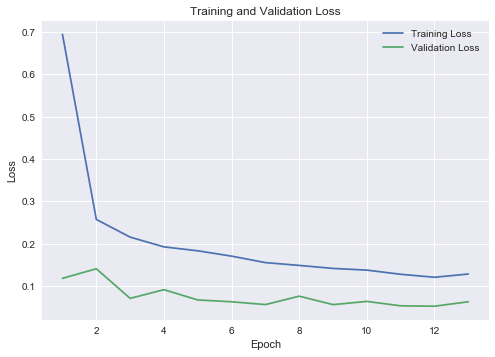

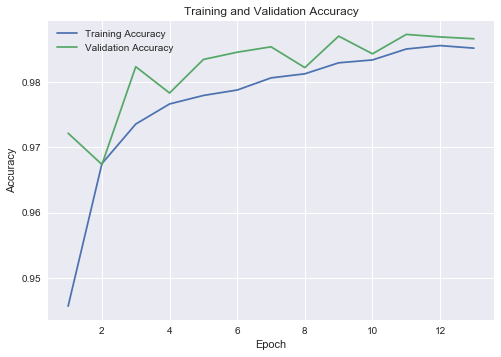


Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      0.99      0.99     56877
        1.0       0.09      0.93      0.17        85

avg / total       1.00      0.99      0.99     56962



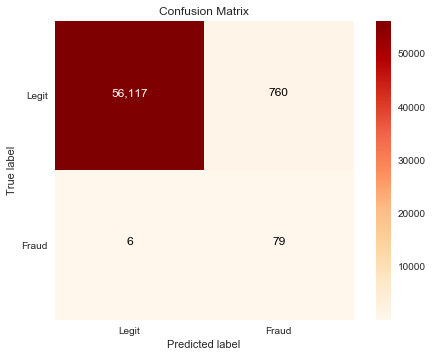

In [85]:
# Weight 100
dnn_plots(history)
predictions = model.predict_classes(X_te)
plot_confusion_matrix(Y_te, predictions,['Legit','Fraud']).show()

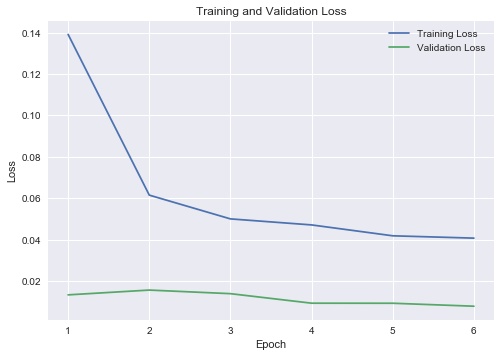

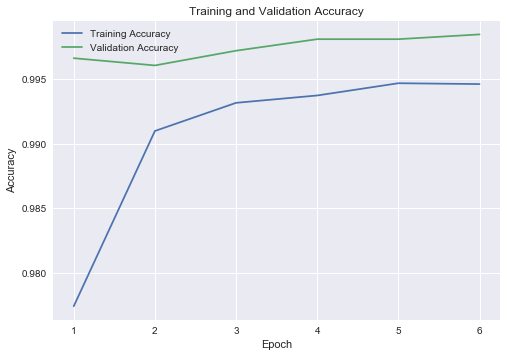


Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     56877
        1.0       0.50      0.89      0.64        85

avg / total       1.00      1.00      1.00     56962



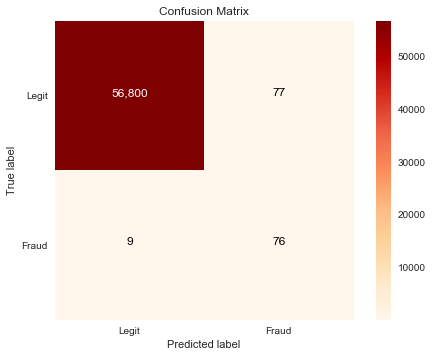

In [83]:
# Weight 10
dnn_plots(history)
predictions = model.predict_classes(X_te)
plot_confusion_matrix(Y_te, predictions,['Legit','Fraud']).show()

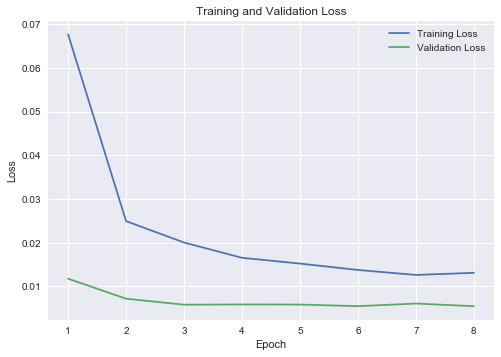

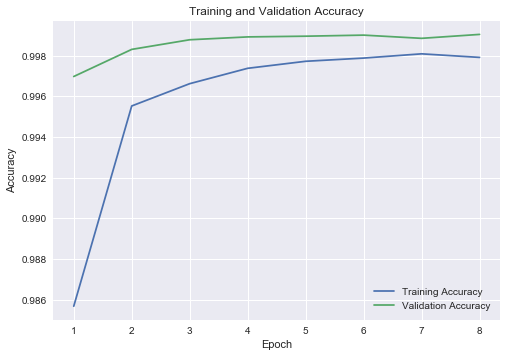


Clasification report:
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     56877
        1.0       0.63      0.87      0.73        85

avg / total       1.00      1.00      1.00     56962



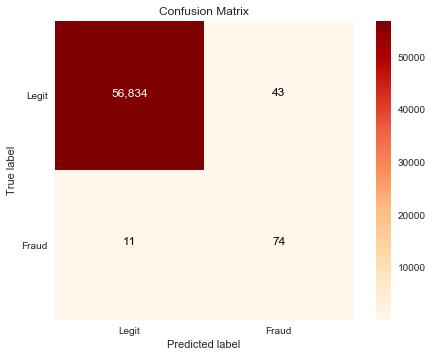

In [81]:
# Weight 3
dnn_plots(history)
predictions = model.predict_classes(X_te)
plot_confusion_matrix(Y_te, predictions,['Legit','Fraud']).show()